* Files
* calendar.csv - Contains information about the dates on which the products are sold.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pmdarima


     |████████████████████████████████| 1.5 MB 5.0 MB/s 
     |████████████████████████████████| 9.5 MB 42.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.graph_objs as go 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller


from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook
from tqdm import tqdm

In [ ]:
calender= pd.read_csv('/content/drive/MyDrive/Data/calendar.csv')
calender.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
sales = pd.read_csv('/content/drive/MyDrive/Data/sales_train_evaluation.csv')
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1


In [ ]:
sales_dept = sales.groupby('dept_id').sum()
sales_dept.head(3)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
dept_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,1586,1785,1737,2048,2349,2948,3688,2193,1552,1617,1502,1866,2391,2164,1784,1480,1587,1542,1744,2432,2019,1464,1691,1588,1626,1759,2193,2301,1540,1456,1482,...,2591,2583,3192,3523,3062,2461,2544,2657,2639,3169,3712,3185,2841,2860,2799,3184,3800,4415,4285,3506,4020,3602,3759,3925,4951,3895,3417,3306,3262,3252,4130,4257,4225,3264,3119,3073,3251,3735,4195,4031
FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,3684,3255,3696,3592,3743,4722,4889,3021,3899,3219,2790,3030,3821,3853,3184,2598,2548,2463,2648,3499,3881,3028,3344,3245,3472,3310,4432,5162,3709,3480,3460,...,5124,5518,5661,5792,6588,5247,4942,4734,4446,4974,5524,6473,4957,4662,4111,4089,4973,5781,7129,6384,6296,5410,5906,5897,6997,6188,7531,5873,6537,5982,5842,7563,9069,6226,5311,4648,4551,4815,5940,6535
FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,13631,11923,12222,11700,12946,17517,18079,10801,11974,10515,9998,11698,14726,14011,11405,9965,9797,9728,11088,13974,14760,10574,11533,11385,12144,12443,16447,17446,12339,11344,11097,...,16173,17355,19829,22692,24847,18443,17462,16241,16232,18561,22691,22996,18155,15997,15962,15642,18895,22527,23955,19252,19278,18187,18528,20585,24804,21752,21958,18152,19504,18908,20135,24756,28153,19668,17718,17069,16935,19586,23464,25401


In [ ]:
sales_item = sales.groupby('item_id').sum()
sales_item.head(3)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,6,5,12,15,16,18,11,10,12,7,17,9,9,8,5,14,26,8,12,13,5,11,10,14,11,8,22,14,6,9,...,6,3,4,4,30,7,5,3,6,2,16,6,4,5,7,1,9,3,9,1,10,3,1,6,10,6,2,5,6,2,7,8,8,4,7,7,5,7,5,9
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,4,3,1,5,8,5,1,3,2,0,4,5,4,2,2,4,3,5,7,3,3,4,7,7,3,4,11,0,1,1,...,5,4,5,9,4,1,3,5,5,3,3,1,9,4,3,4,5,7,2,5,6,3,2,4,5,3,1,6,3,10,5,8,7,2,6,5,0,6,6,4
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,11,10,3,17,20,14,10,9,3,14,7,23,16,7,12,6,5,7,10,6,10,6,8,3,9,18,18,11,8,4,...,4,1,7,3,5,6,3,4,4,3,11,5,7,13,9,1,2,4,7,9,2,3,13,5,9,5,0,6,3,10,7,8,6,11,9,7,7,10,6,5


In [ ]:
sales_cat = sales.groupby('cat_id').sum().T
sales_cat.head(3)

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_1,23178,3764,5689
d_2,22758,3357,5634
d_3,17174,2682,3927


In [ ]:
sales_cat.index

Index(['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1941)

In [ ]:
sales_cat['days'] =  sales_cat.index

In [ ]:
sales_store = sales.groupby('store_id').sum()
sales_state = sales.groupby('state_id').sum()

In [ ]:
#sales_calender = calender.iloc[:,[0,2,3,4,5,6,7]]
sales_calender = calender

sales_cat = pd.merge(sales_calender,sales_cat,how = 'inner', left_on = 'd', right_on = 'days')

sales_cat['date'] = pd.to_datetime(sales_cat['date'])
sales_cat = sales_cat.set_index('date')


In [ ]:
sales_cat = sales_cat.iloc[:,[-4,-3,-2]]
sales_cat.head(3)

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-29,23178,3764,5689
2011-01-30,22758,3357,5634
2011-01-31,17174,2682,3927


In [ ]:
sales_cat.tail(3)

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2016-05-20,28136,4143,10273
2016-05-21,33599,5333,12586
2016-05-22,35967,5280,13091


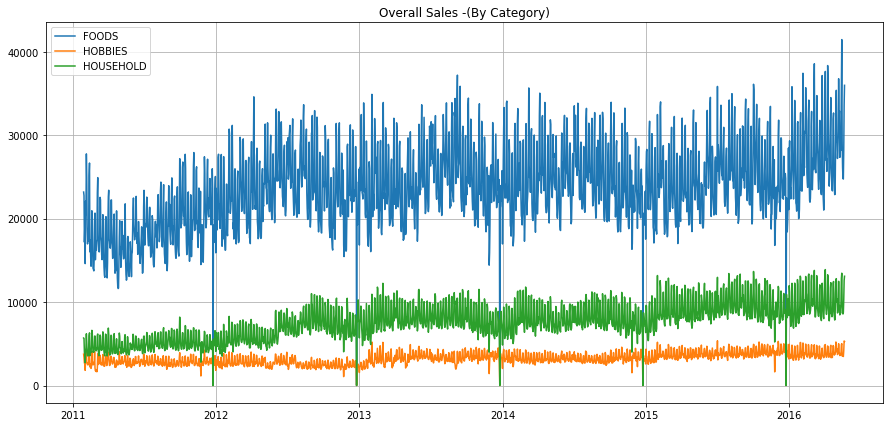

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(sales_cat.FOODS)
plt.title('Overall Sales -(By Category)')
plt.plot(sales_cat.HOBBIES)
plt.plot(sales_cat.HOUSEHOLD)
plt.grid(True)
plt.legend(sales_cat.columns)
plt.show()

In [ ]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#**Moving Average**

In [ ]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(sales_cat.FOODS, 150) # prediction for the last observed day (past 24 hours)

27563.653333333332

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

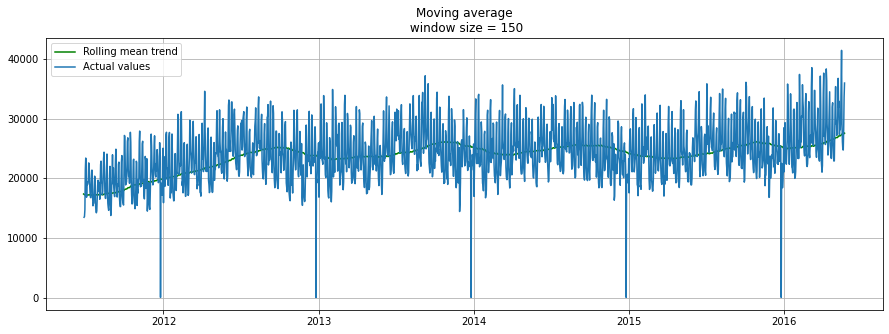

In [ ]:
plotMovingAverage(sales_cat.FOODS, 150) 

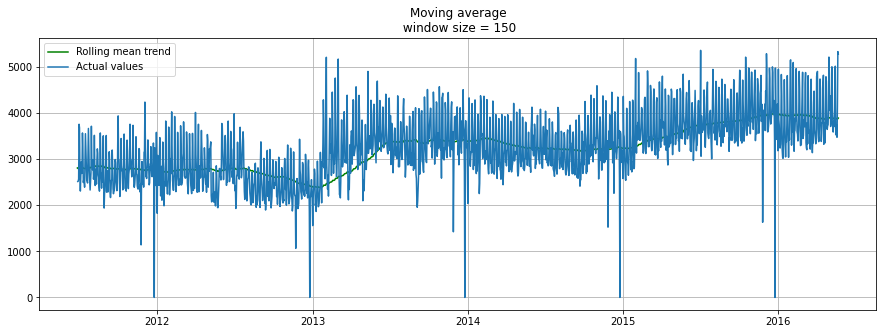

In [ ]:
plotMovingAverage(sales_cat.HOBBIES, 150) 

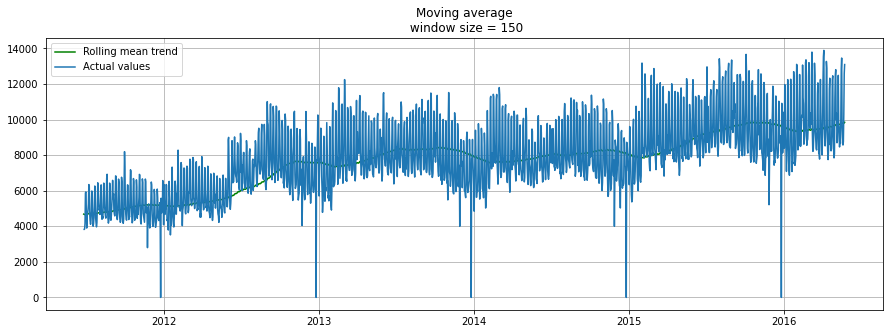

In [ ]:
plotMovingAverage(sales_cat.HOUSEHOLD, 150) 

#**Exponential Smoothing**

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-dark'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), '--',label="Alpha {}".format(alpha))
        plt.plot(series.values, "c",label = "Actual", color = 'grey')
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

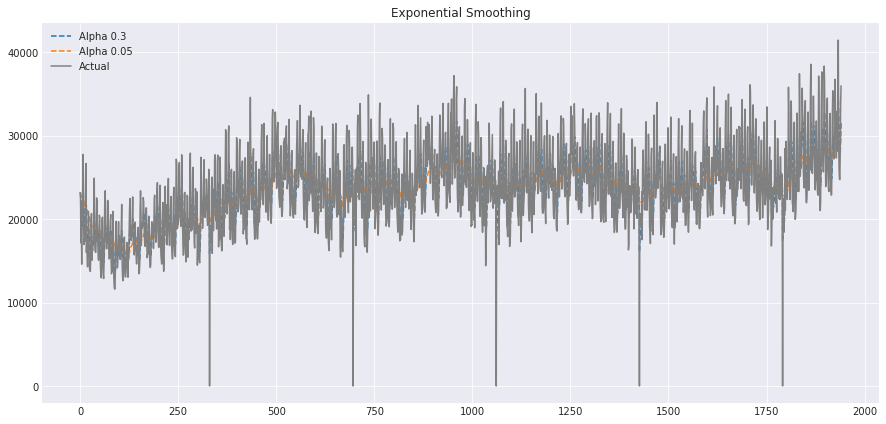

In [ ]:
plotExponentialSmoothing(sales_cat.FOODS, [0.3, 0.05])

# **Double Exponential Smoothing**

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

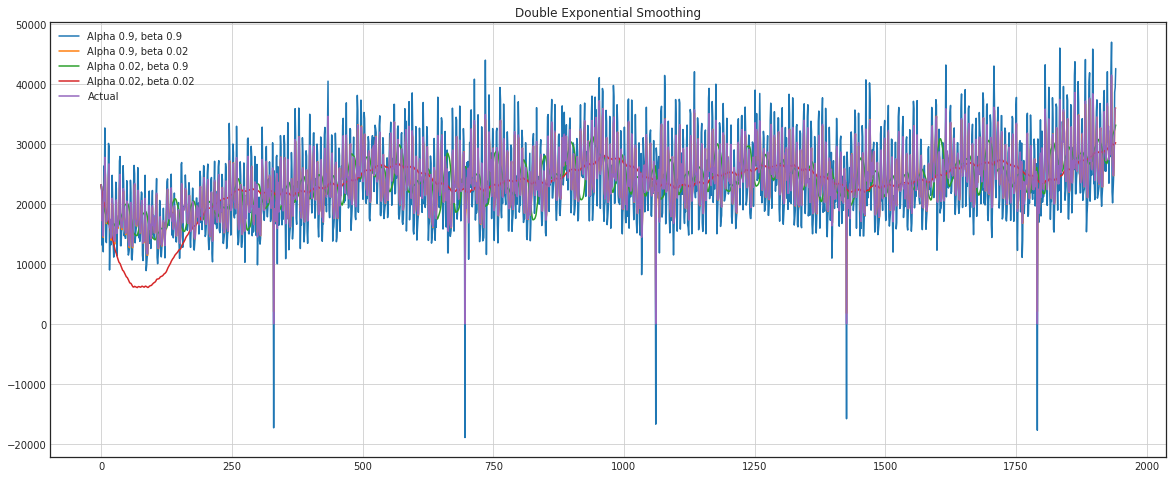

In [ ]:
plotDoubleExponentialSmoothing(sales_cat.FOODS, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [ ]:
sales_overall = pd.DataFrame(sales_cat.sum(axis = 1), columns=['total_sales'])

In [ ]:
sales_overall.head()

,total_sales
date,
2011-01-29,32631
2011-01-30,31749
2011-01-31,23783
2011-02-01,25412
2011-02-02,19146


In [ ]:
sales_overall.dtypes

total_sales    int64
dtype: object

In [ ]:
sales_overall.drop(sales_overall[sales_overall.total_sales <= 20].index, inplace=True)

In [ ]:
sales_overall.shape

(1936, 1)

In [ ]:
sales_overall.head

<bound method NDFrame.head of             total_sales
date                   
2011-01-29        32631
2011-01-30        31749
2011-01-31        23783
2011-02-01        25412
2011-02-02        19146
...                 ...
2016-05-18        37096
2016-05-19        36963
2016-05-20        42552
2016-05-21        51518
2016-05-22        54338

[1936 rows x 1 columns]>

In [ ]:
sales_overall = sales_overall.resample('D').ffill().reset_index()

In [ ]:
sales_overall.head()

,date,total_sales
0,2011-01-29,32631
1,2011-01-30,31749
2,2011-01-31,23783
3,2011-02-01,25412
4,2011-02-02,19146


In [ ]:
sales_overall['date'] = pd.to_datetime(sales_overall['date'], format='%Y-%m-%d %H:%M:%S')
sales_overall.set_index('date',inplace=True)

In [ ]:
sales_overall

,total_sales
date,
2011-01-29,32631
2011-01-30,31749
2011-01-31,23783
2011-02-01,25412
2011-02-02,19146
...,...
2016-05-18,37096
2016-05-19,36963
2016-05-20,42552


# SARIMA

**Building SARIMA**

* p and seasonal P: indicate the number of AR terms (lags of the stationary series)
* d and seasonal D: indicate differencing that must be done to stationary series
* q and seasonal Q: indicate the number of MA terms (lags of the forecast errors)
* lag: indicates the seasonal length in the data

* Identify variance, trend and seasonality in data

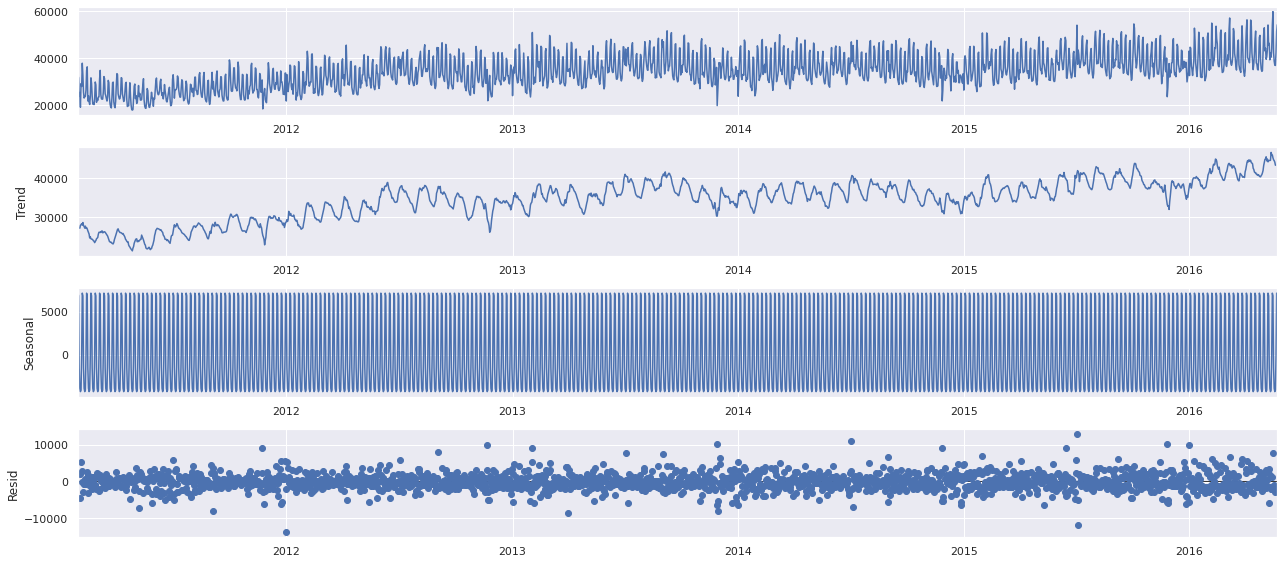

In [ ]:
from pylab import rcParams

sns.set_theme()
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(sales_overall, model="additive")
fig = decomposition.plot()
plt.show()

* Increasing Trend
* Weekly seasonality ??

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

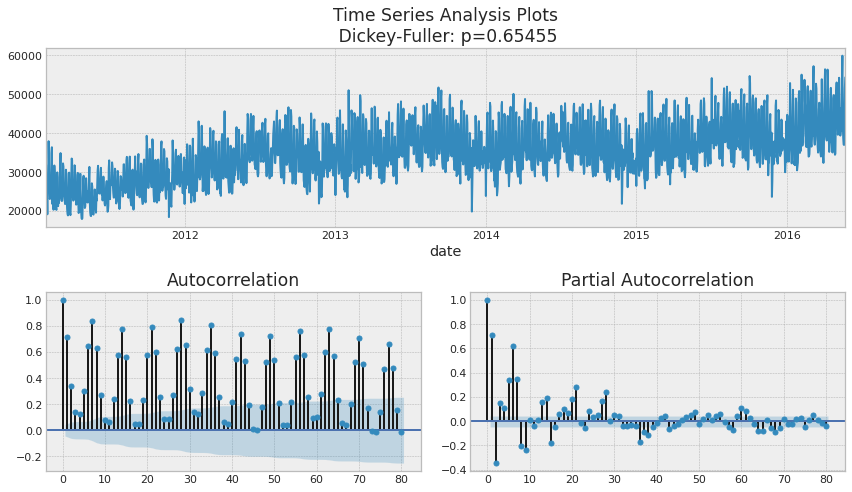

In [ ]:
tsplot(sales_overall.total_sales, lags=80)

* p-value > critical value(0.05)
* Series not stationary
* Take first order differencing and rerun the ADF test

In [ ]:
total_sales_diff = sales_overall.total_sales- sales_overall.total_sales.shift(1)

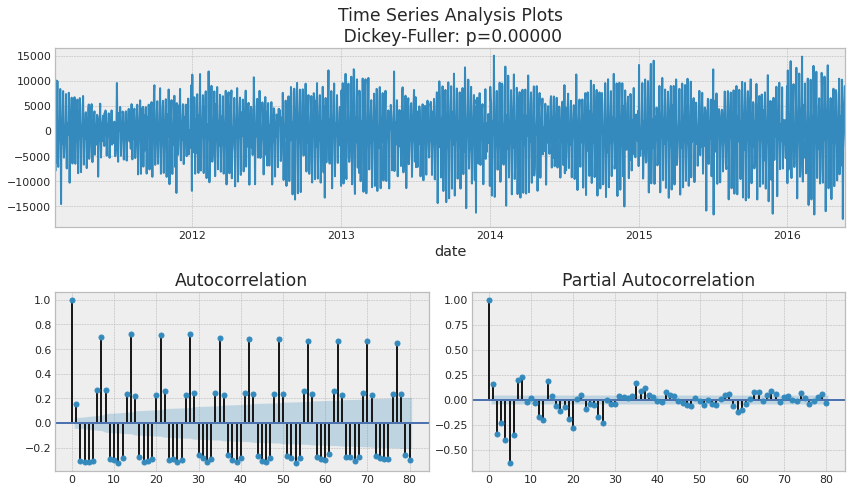

In [ ]:
total_sales_diff
tsplot(total_sales_diff[1:], lags=80)

* Series is stationary now
* Series is showing a weekly seasonality
* Do a differencing with a lag of 7

In [ ]:
total_sales_diff_sadj = total_sales_diff- total_sales_diff.shift(7)

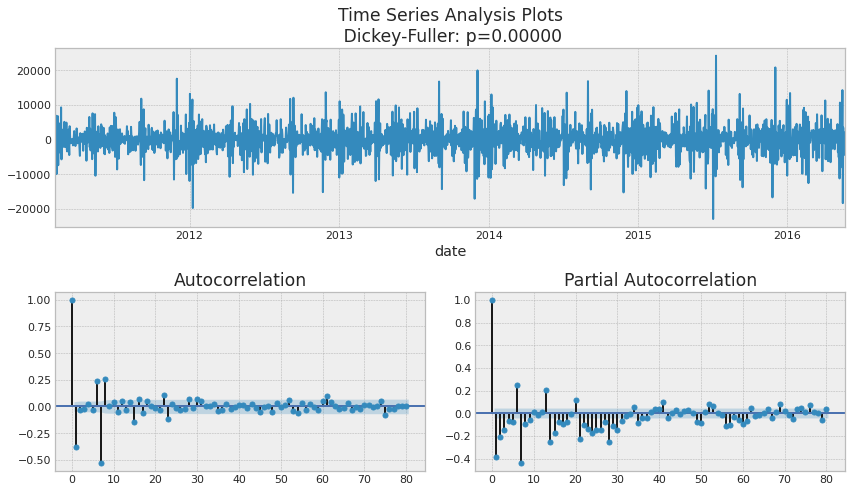

In [ ]:
tsplot(total_sales_diff_sadj[1+7:], lags = 80)

* For ACF plot, initial spikes at lag = 1 and seasonal spikes at lag = 7, which means a probable AR order of 1 and seasonal AR order of 1

* For PACF plot, initial spikes at lag = 1 and seasonal spikes at lag = 7, which means a probable MA order of 1 or 2 and seasonal MA order of 1

* Probable SARIMA eq - SARIMA(1,1,1)x(1,1,1)7

In [ ]:
# setting initial values and some bounds for them
p = range(0, 4)
d= range(1,2)
q = range(0, 3)
s = 7

seasonal_parameters = [(x[0], x[1], x[2], s) for x in list(product(p, d, q))]

# season length 7 days

# creating list with all the possible combinations of parameters
parameters = product(p, d, q)
parameters_list = list(parameters)
len(parameters_list)

12

In [ ]:
print(parameters_list)
print(seasonal_parameters)

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (3, 1, 0), (3, 1, 1), (3, 1, 2)]
[(0, 1, 0, 7), (0, 1, 1, 7), (0, 1, 2, 7), (1, 1, 0, 7), (1, 1, 1, 7), (1, 1, 2, 7), (2, 1, 0, 7), (2, 1, 1, 7), (2, 1, 2, 7), (3, 1, 0, 7), (3, 1, 1, 7), (3, 1, 2, 7)]


In [ ]:
def optimizeSARIMA(series, parameters_list, seasonal_parameters):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")
    for param in tqdm(parameters_list):
      for seasonal_param in tqdm(seasonal_parameters):
          # we need try-except because on some combinations model fails to converge
          try:
              model=sm.tsa.statespace.SARIMAX(series, order=param, 
                                              seasonal_order=seasonal_param).fit(disp=-1)
          except:
              continue
          aic = model.aic
          # saving best model, AIC and parameters
          if aic < best_aic:
              best_model = model
              best_aic = aic
              best_param = param
              best_seasonal_param = seasonal_param
          results.append([param, seasonal_param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'seasonal_param','aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
model=sm.tsa.statespace.SARIMAX(sales_overall.total_sales, order=(2, 1, 2), 
                                            seasonal_order=(1, 1,1, 7)).fit(disp=-1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
%%time
result_table = optimizeSARIMA(sales_overall.total_sales, parameters_list, seasonal_parameters)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.


  8%|▊         | 1/12 [00:00<00:01,  8.77it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.


 17%|█▋        | 2/12 [00:01<00:11,  1.12s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/li

CPU times: user 43min 40s, sys: 31min 21s, total: 1h 15min 2s
Wall time: 38min 28s


In [ ]:
result_table.head()

,parameters,seasonal_param,aic
0,"(2, 1, 1)","(0, 1, 2, 7)",36043.193764
1,"(3, 1, 1)","(0, 1, 2, 7)",36045.905442
2,"(1, 1, 2)","(0, 1, 2, 7)",36050.880428
3,"(3, 1, 1)","(0, 1, 1, 7)",36056.604187
4,"(2, 1, 1)","(0, 1, 1, 7)",36068.369252


In [ ]:
result_table.parameters[0]

(2, 1, 1)

In [ ]:
# set the parameters that give the lowest AIC
p, d, q = result_table.parameters[0]
P, D, Q, s = result_table.seasonal_param[0]

best_model=sm.tsa.statespace.SARIMAX(sales_overall.total_sales, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                       SARIMAX Results                                        
Dep. Variable:                            total_sales   No. Observations:                 1941
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood              -18015.597
Date:                                Wed, 01 Sep 2021   AIC                          36043.194
Time:                                        13:03:29   BIC                          36076.595
Sample:                                    01-29-2011   HQIC                         36055.479
                                         - 05-22-2016                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4786      0.015     31.285      0.000       0.449       0.509
ar.

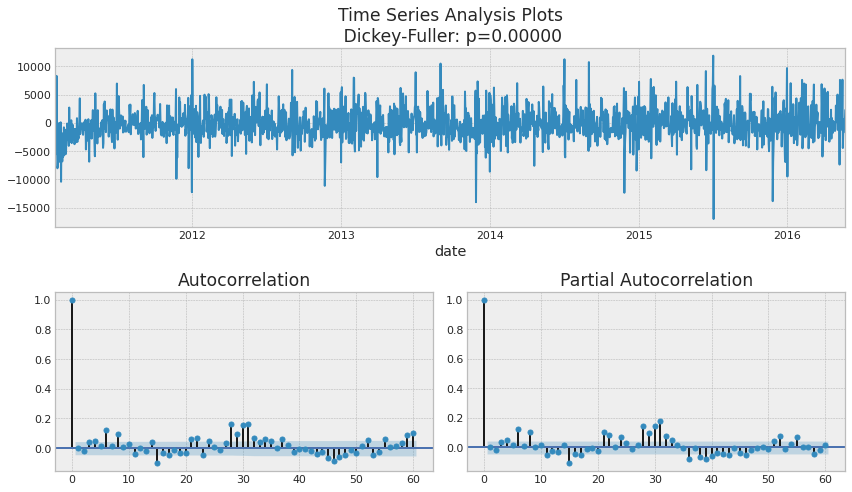

In [ ]:
tsplot(best_model.resid[0+1:], lags=60)

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    #print(data)
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    #print(data['actual'][s+d:])
    #print(data['arima_model'][s+d:])
    plt.figure(figsize=(15, 7))
    #plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.title("Walmart Data: Actual vs Predicted")
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



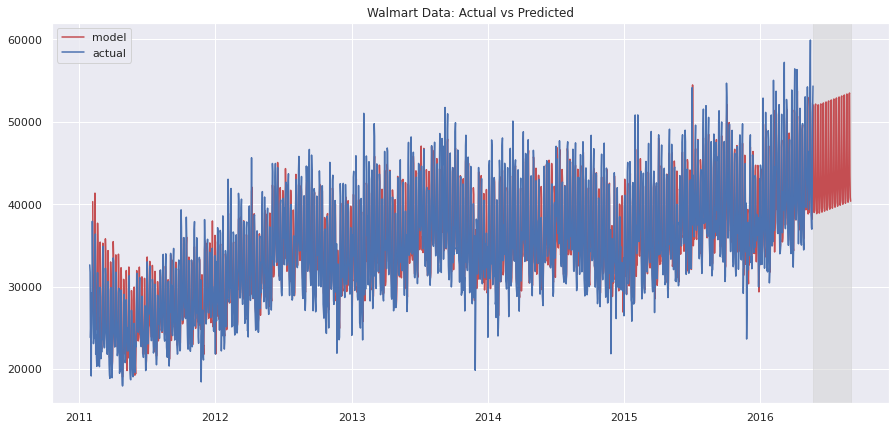

In [ ]:
plotSARIMA(pd.DataFrame(sales_overall.total_sales), best_model, 100)

In [ ]:
mean_absolute_percentage_error(sales_overall.total_sales[-182:], best_model.fittedvalues[-183:-1])

5.929632329797329

In [ ]:
mean_absolute_error(sales_overall.total_sales[-182:], best_model.fittedvalues[-183:-1])

5113.0923301871435

In [ ]:
np.sqrt(mean_squared_error(sales_overall.total_sales[-182:], best_model.fittedvalues[-183:-1]))

6570.61603506916

In [ ]:
data = sales_overall.total_sales.copy()
data

date
2011-01-29    32631
2011-01-30    31749
2011-01-31    23783
2011-02-01    25412
2011-02-02    19146
              ...  
2016-05-18    37096
2016-05-19    36963
2016-05-20    42552
2016-05-21    51518
2016-05-22    54338
Name: total_sales, Length: 1936, dtype: int64

In [ ]:
data.columns = ['actual']

In [ ]:
data['arima_model'] = best_model.fittedvalues
data.shape

(1937,)

In [ ]:
s

7

In [ ]:
data['arima_model'][:s+d] = np.nan

In [ ]:
data

In [ ]:
forecast = model.predict(start = data.shape[0], end = data.shape[0]+100)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

